<a href="https://colab.research.google.com/github/tanmy-sharma/DiabetesPrediction/blob/main/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes Prediction 

In this notebook, I would like to test out a diabetes dataset in order to accurately predict whether or not the person has diabetes by the state of their health factors provided in the dataset.

## Load Libraries

In [74]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

### Reading the dataset

In [ ]:
df = pd.read_csv('/content/diabetes_binary.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## EDA

Checking for empty values

In [ ]:
[features for features in df.columns if df[features].isnull().sum() > 0]

[]

<Axes: >

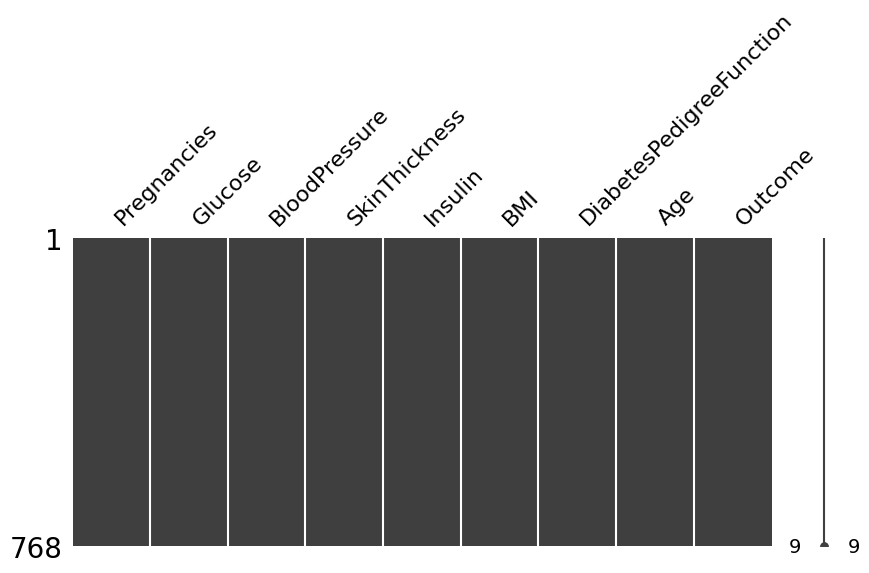

In [ ]:
# another way to give a visual representation

import missingno as msno
msno.matrix(df, figsize = (10,4))

As we can see from above, we have **no missing data**.

### Checking target Imbalance

In [ ]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

([<matplotlib.patches.Wedge at 0x7f85ba9a9580>,
 [Text(-0.5025943242672991, 0.9784676515931925, ''),
  Text(0.5025944158780503, -0.9784676045369114, '')])

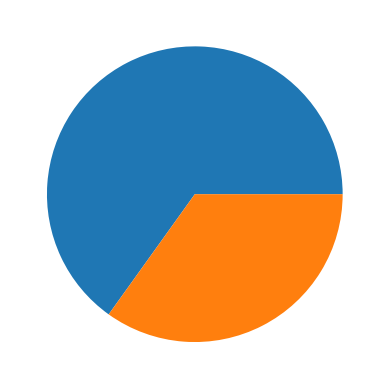

In [ ]:
plt.pie(df['Outcome'].value_counts())

**Data is balanced.**

## Checking Statistics

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We can see that some of the minimum values of the columns like Glucose, Skin Thickness is zero, which should not be zero. So, I am going to replace all the values of zero to the mean of the concerned column.

In [ ]:
zero_columns = []

for column in df.columns:
  if df[column][df[column] == 0].count() > 0:
    zero_columns.append(column)

zero_columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'Outcome']

These columns have 0 in their values but pregnancies can be zero, so we will remove that. Outcome is 0 and 1, so we need to remove that column as well.

In [ ]:
zero_columns.remove('Pregnancies')
zero_columns.remove('Outcome')
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

Replacing 0's with mean values

In [ ]:
diabetes_zero_mean = df[zero_columns].mean()
df[zero_columns] = df[zero_columns].replace(0, diabetes_zero_mean)

Checking graphs of all features 

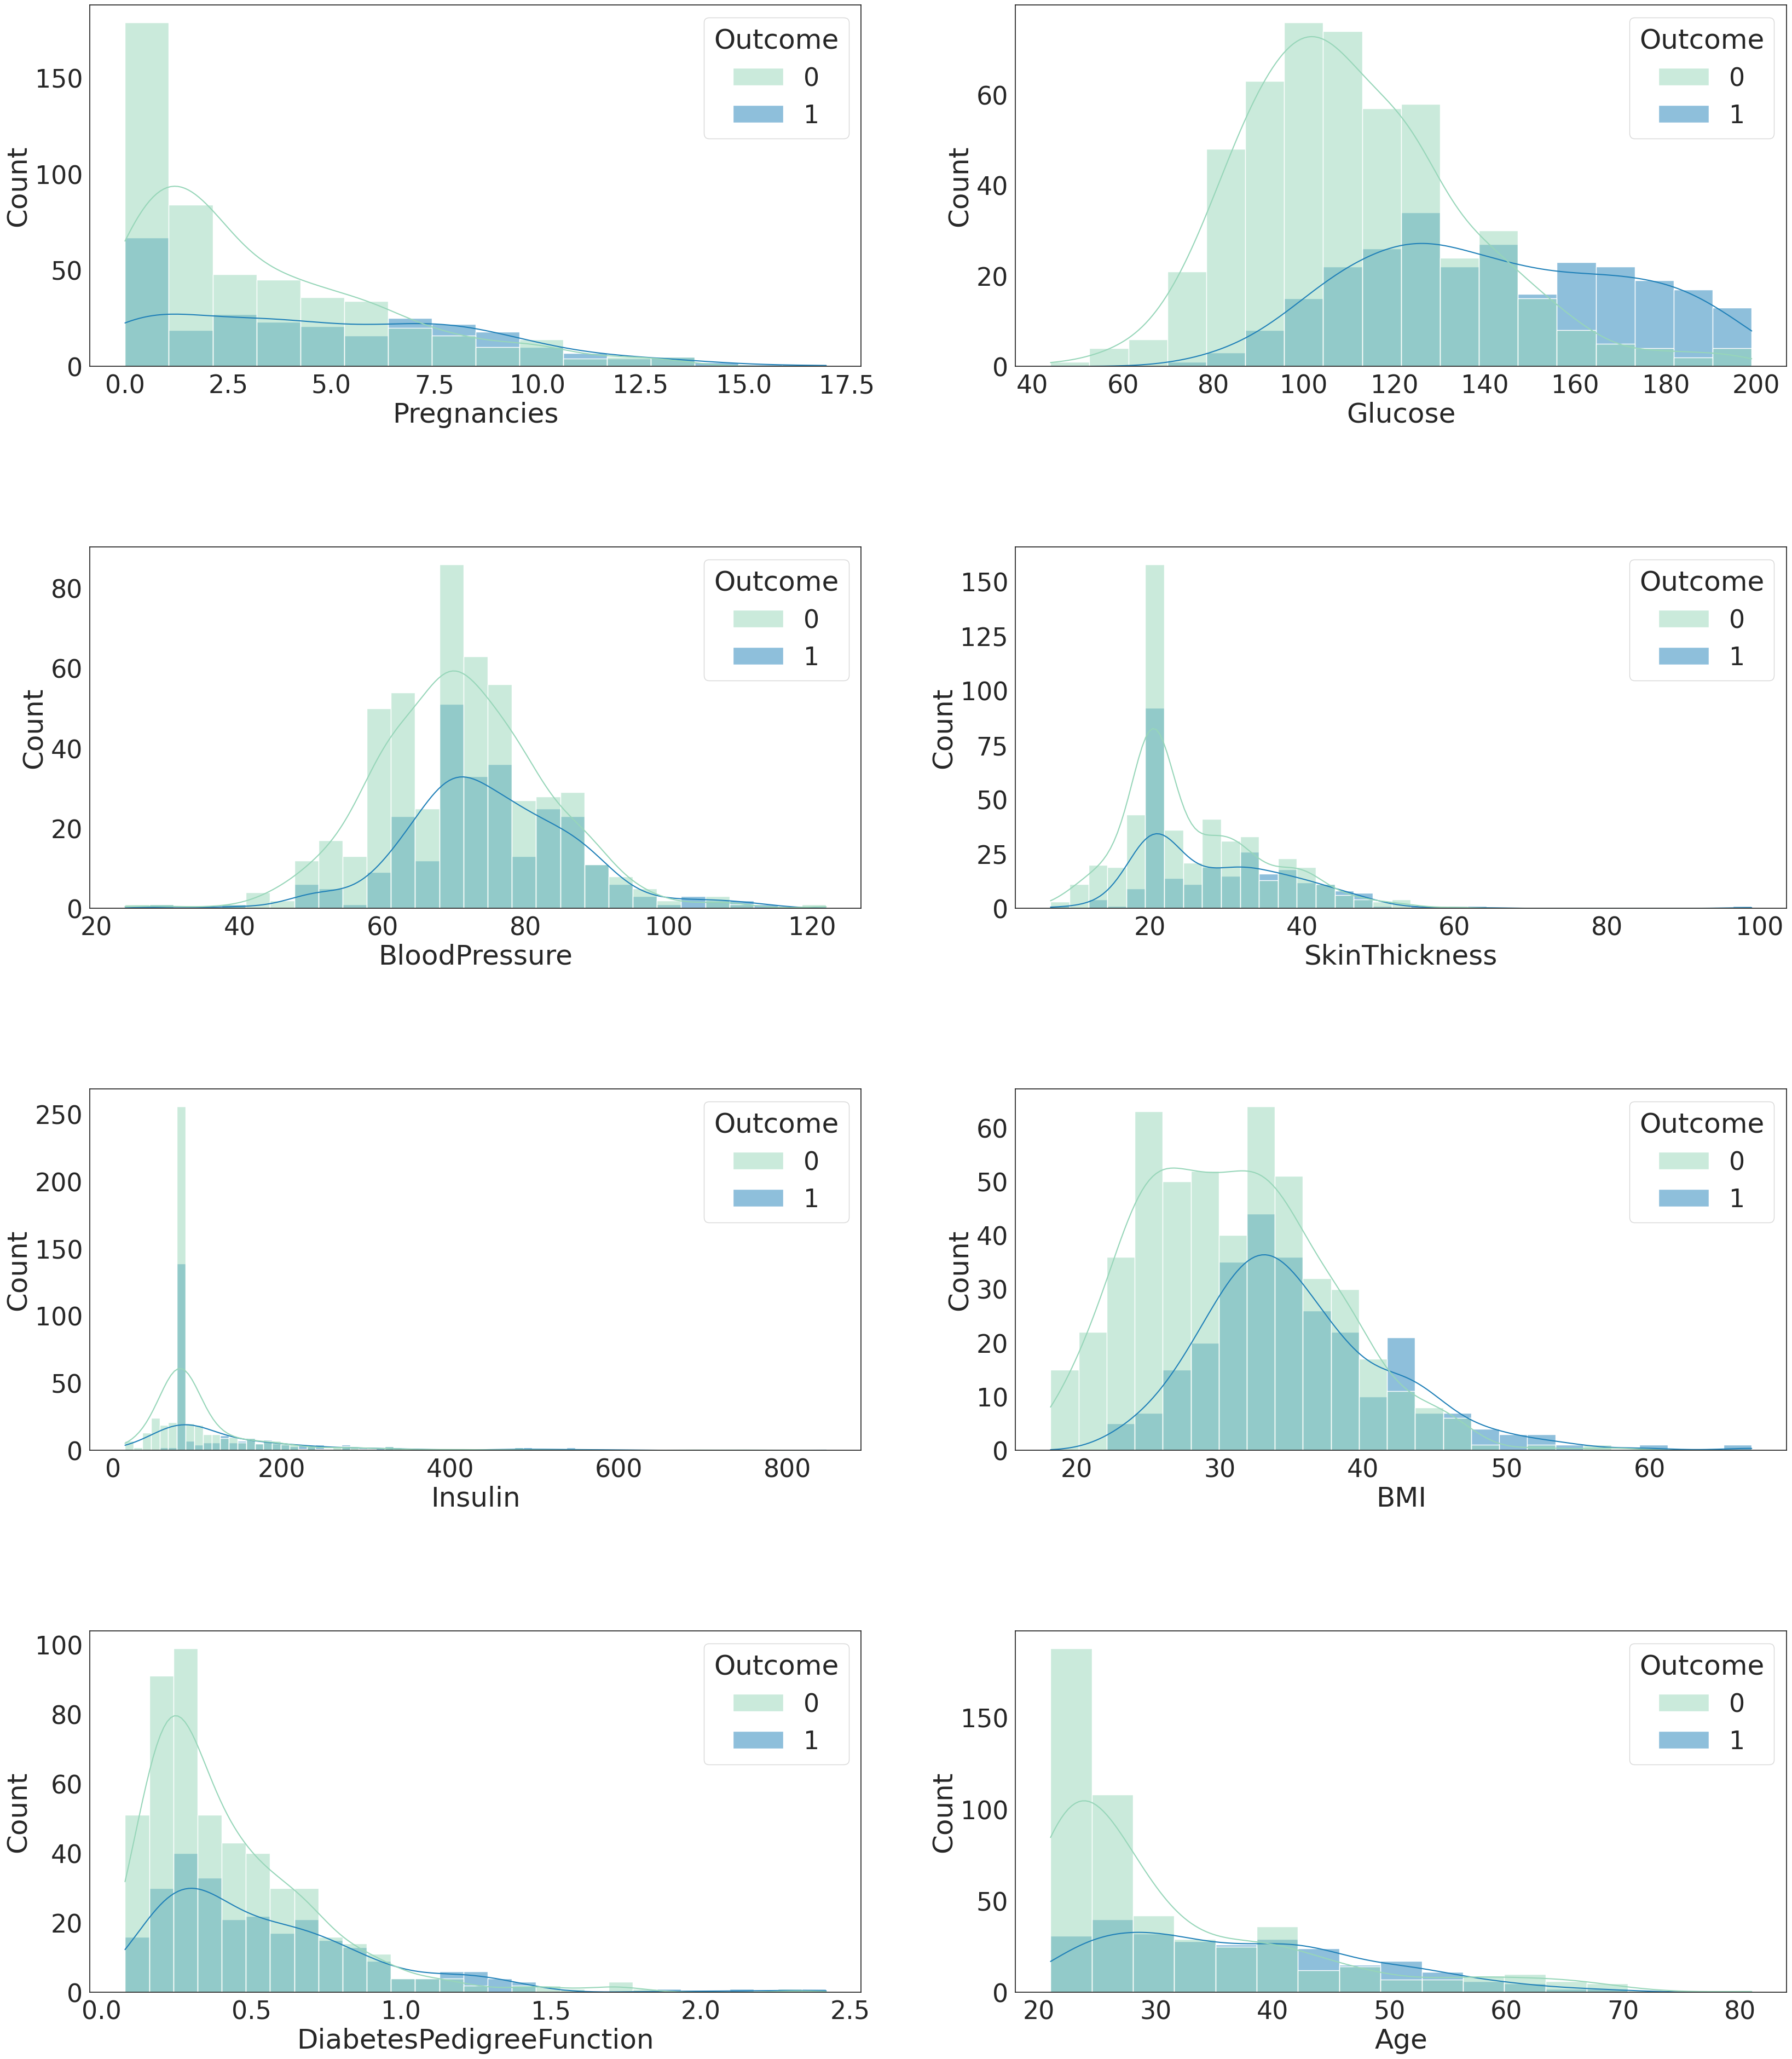

In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for columns in df.columns:
  if columns != 'Outcome':
      plt.subplot(5,2,i)
      sns.histplot(data=df, x=columns, hue="Outcome",kde=True,palette="YlGnBu")
      i = i + 1

### Checking the co-relation between features

<Axes: >

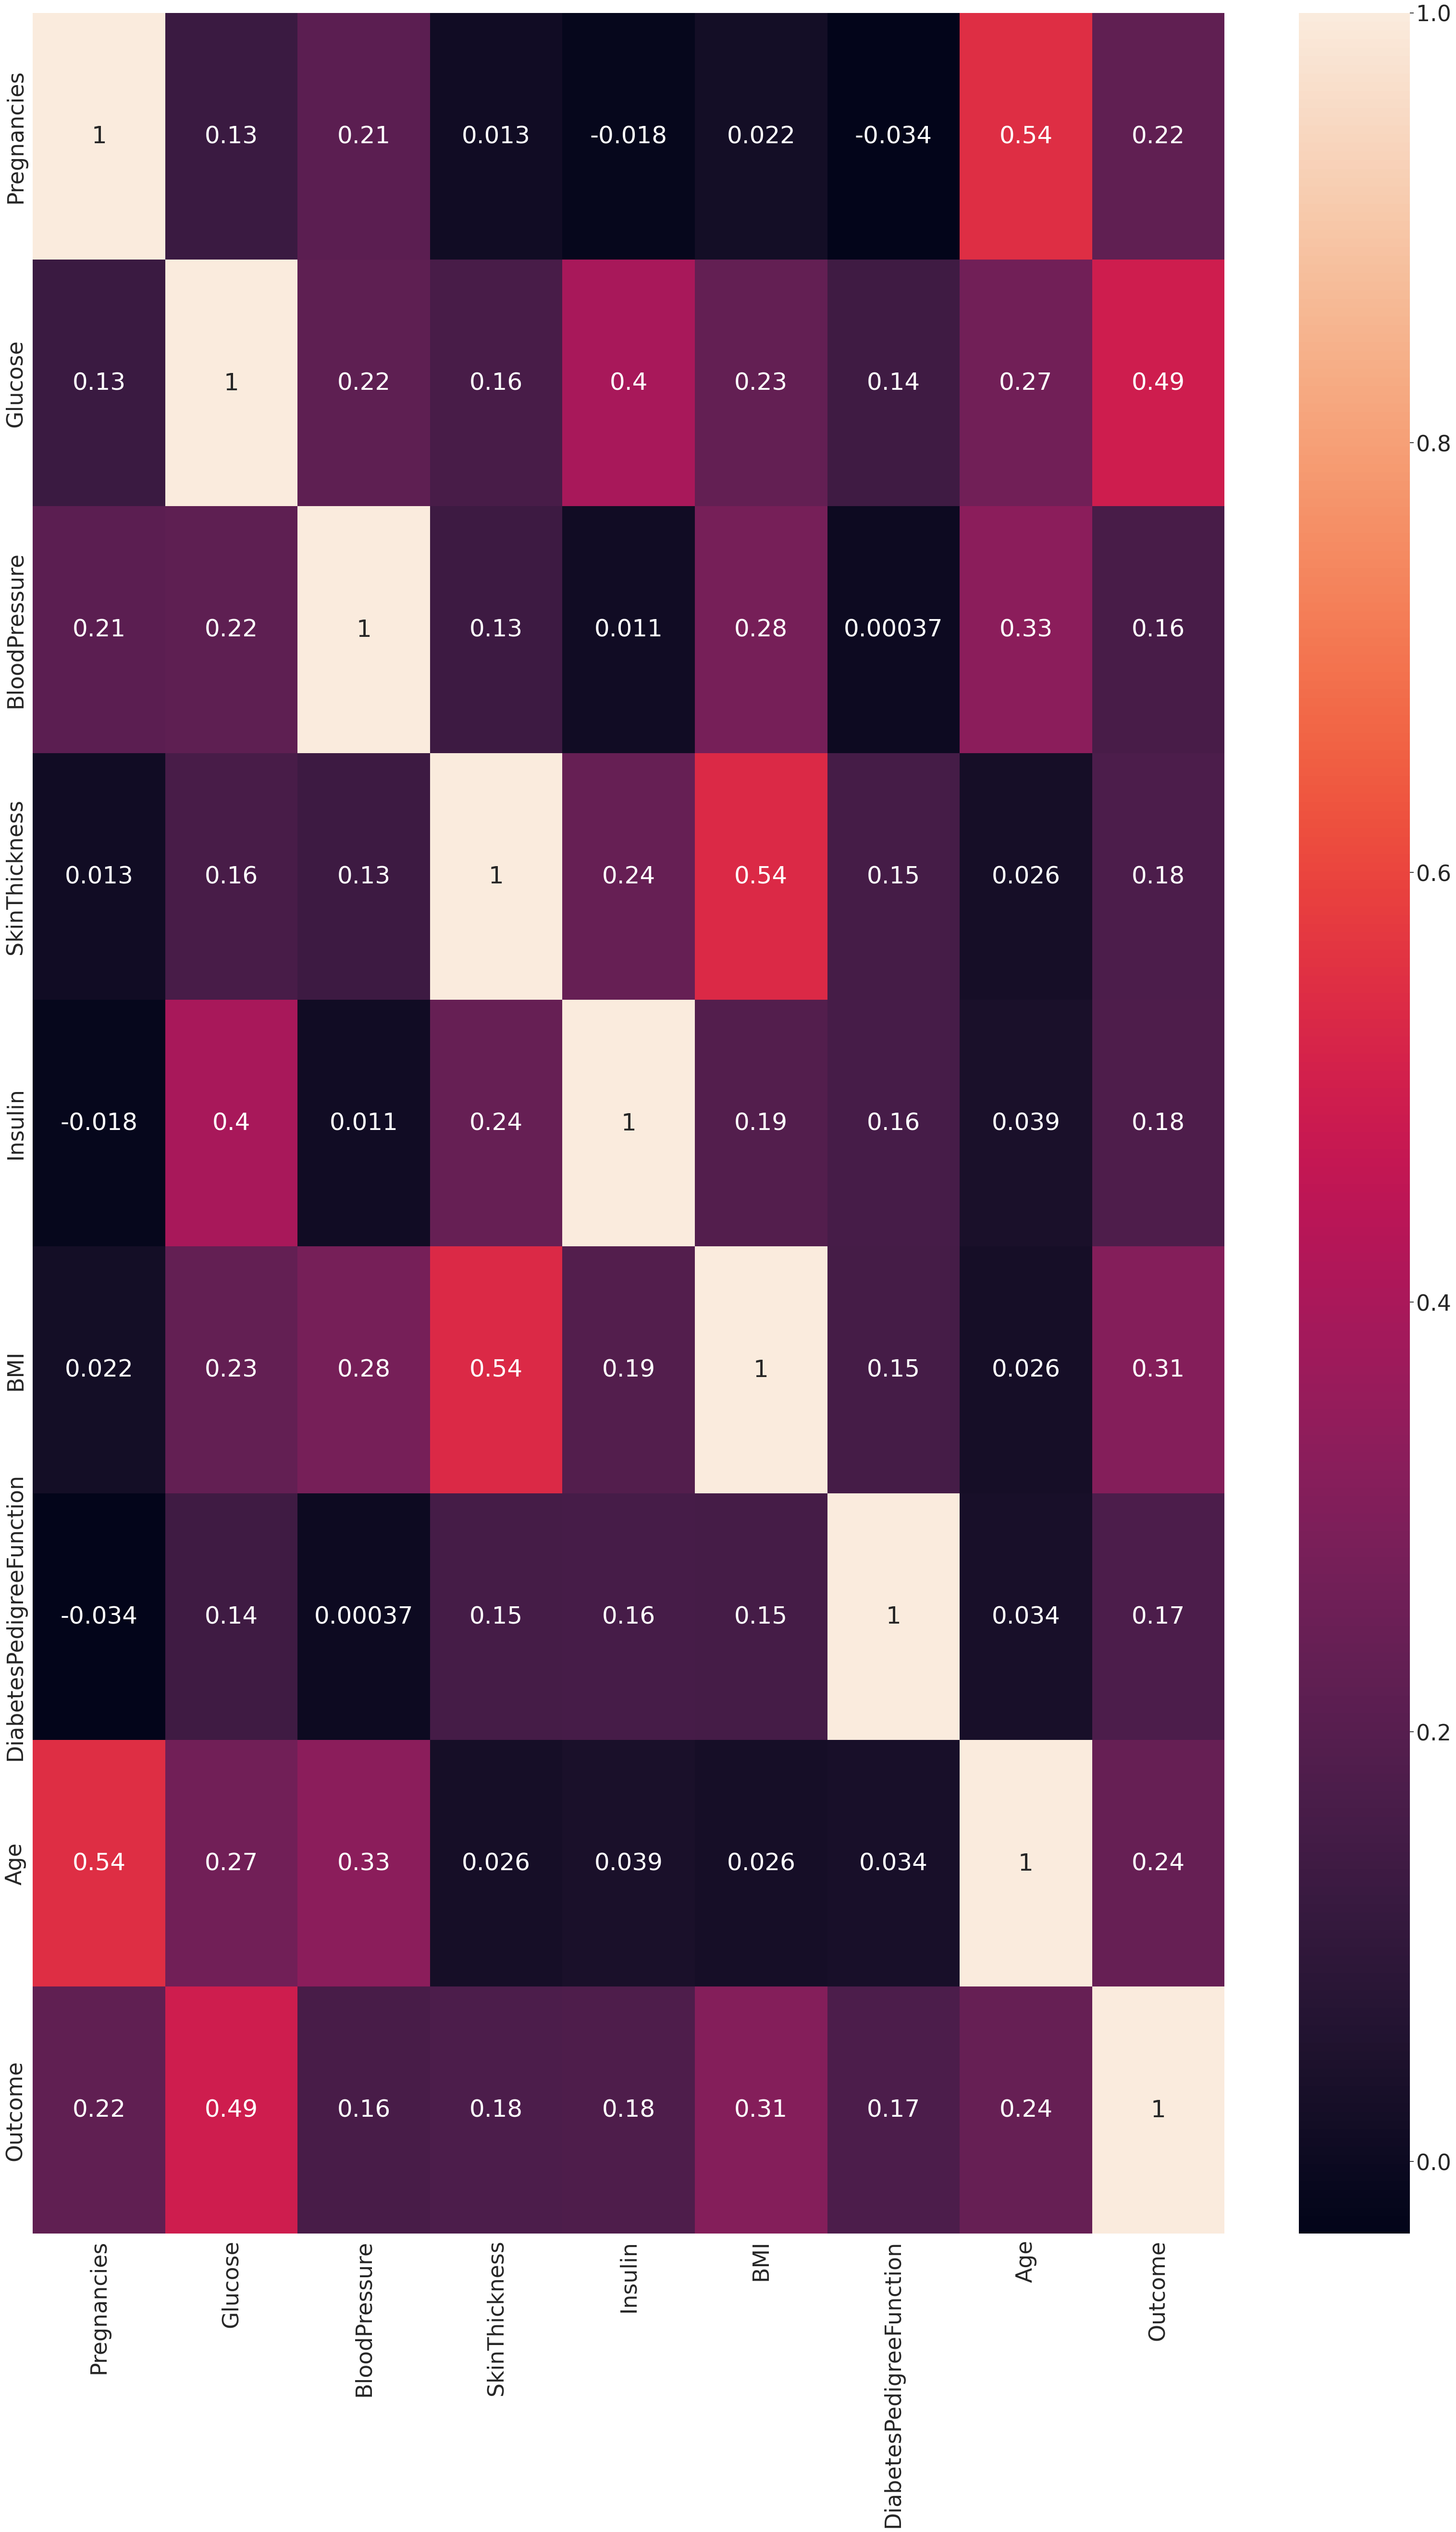

In [ ]:
sns.heatmap(df.corr(), annot = True)

## Observations:

1. Given the correlation of glucose and outcome is high, Glucose might be the most important aspect in the dataset.

2. Skin Thickness, BMI, and Diabetes Pedigree Function seems to be related to each other.

3. After glucose, BMI, age and number of pregnancies seem to be of importance.

## Spliting data

In [ ]:
x = df.drop(columns = 'Outcome', axis = 1)
y = df['Outcome']
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 48.1 KB


In [ ]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 768 entries, 0 to 767
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


**Preprocessing the data**

In [ ]:
x = StandardScaler().fit_transform(x)

**Splitting it**

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 10, stratify = y, test_size = 0.25)

We have our training and testing data now. Time to train some models.

## Model Training

So, I am going to train these few models and compare their accuracy:

In [60]:
dic_accuracy = {}

**Logistic Regression**

In [63]:
model_logistic_regression = LogisticRegression(random_state = 0)
model_logistic_regression.fit(x_train, y_train)

lr_pred = model_logistic_regression.predict(x_test)
dic_accuracy['LR'] = accuracy_score(y_test, lr_pred)
dic_accuracy['LR']

0.8020833333333334

**Support Vector Machine(SVM)**

In [64]:
model_svm = SVC().fit(x_train, y_train)
svm_predict = model_svm.predict(x_test)
dic_accuracy['SVM'] = accuracy_score(y_test, svm_predict)
dic_accuracy['SVM']

0.78125

**K Nearest Neighbours(KNN)**

In [65]:
model_knn = KNeighborsClassifier().fit(x_train, y_train)
knn_predict = model_knn.predict(x_test)
dic_accuracy['KNN'] = accuracy_score(y_test, knn_predict)
dic_accuracy['KNN']

0.7447916666666666

**Naive Bayers**

In [66]:
model_NB = GaussianNB().fit(x_train, y_train)
NB_predict = model_NB.predict(x_test)
dic_accuracy['NB'] = accuracy_score(y_test, NB_predict)
dic_accuracy['NB']

0.7760416666666666

**Decision Trees**

In [67]:
model_DT = DecisionTreeClassifier().fit(x_train, y_train)
DT_predict = model_DT.predict(x_test)
dic_accuracy['DT'] = accuracy_score(y_test, DT_predict)
dic_accuracy['DT']

0.71875

**Random Forest**

In [68]:
model_RF = RandomForestClassifier().fit(x_train, y_train)
RF_predict = model_RF.predict(x_test)
dic_accuracy['RF'] = accuracy_score(y_test, RF_predict)
dic_accuracy['RF']

0.8020833333333334

**Comaparing Accuracy**

In [70]:
dic_accuracy = dict(sorted(dic_accuracy.items(), key=lambda item: item[1], reverse=True))
for key in dic_accuracy:
  print(key, " : ", dic_accuracy[key])

LR  :  0.8020833333333334
RF  :  0.8020833333333334
SVM  :  0.78125
NB  :  0.7760416666666666
KNN  :  0.7447916666666666
DT  :  0.71875


Since Logistic regression, Random Forest, and Support Vector Machine are the top three models, we are going to make an ensemble model using them.

**Ensemble Models**

In [75]:
base_models = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC())
]

meta_model = LogisticRegression()

stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_classifier.fit(x_train, y_train)

stacking_predict = stacking_classifier.predict(x_test)
stacking_accuracy = accuracy_score(y_test ,stacking_predict)
dic_accuracy['Stacking'] = stacking_accuracy
stacking_accuracy

0.8072916666666666

That score was not far off from what we got from Logistic Regression so it's not worth it.

In [76]:
dic_accuracy = dict(sorted(dic_accuracy.items(), key=lambda item: item[1], reverse=True))
for key in dic_accuracy:
  print(key, " : ", dic_accuracy[key])

Stacking  :  0.8072916666666666
LR  :  0.8020833333333334
RF  :  0.8020833333333334
SVM  :  0.78125
NB  :  0.7760416666666666
KNN  :  0.7447916666666666
DT  :  0.71875
